In [10]:
# create ostin.txt from a template file
# how to deal with parameters with different dims such as pft?


import os, sys, time, pathlib, subprocess
import xarray as xr
import pandas as pd
import numpy as np


# infile_lndin = sys.argv[1]
# infile_ostin_template = sys.argv[2]
# infile_calibparam = sys.argv[3]
# outfile_ostin_txt = sys.argv[4]

infile_lndin = '/glade/work/guoqiang/CTSM_CAMELS/Calib_HH_Ostrich/level1_626/Buildconf/clmconf/lnd_in'
infile_ostin_template = '/glade/u/home/guoqiang/CTSM_repos/CTSM_calibration/src/Ostrich_support/ostIn_meanerr_DDS.tpl'
infile_calibparam = '/glade/u/home/guoqiang/level1_626_OSTRICHcalib/parameters/calib_parameter_info.csv'
outfile_ostin_txt = 'test.txt'

trial_num = 400
OstrichWarmStart = 'no'

########################################################################################################################
# base files
df_calibparam = pd.read_csv(infile_calibparam)

# base parameter file
dftmp = df_calibparam[df_calibparam['Source'] == 'Param']
if len(dftmp) > 0:
    infile_param = dftmp.iloc[0]['Source_file']
    ds_param = xr.load_dataset(infile_param)
else:
    infile_param = ''
    ds_param = []

# base parameter file
dftmp = df_calibparam[df_calibparam['Source'] == 'Surfdata']
if len(dftmp) > 0:
    infile_surfdata = dftmp.iloc[0]['Source_file']
    ds_surf = xr.load_dataset(infile_surfdata)
else:
    infile_surfdata = ''
    ds_surf = []

# land mask file
cwd = os.getcwd()
os.chdir(pathlib.Path(infile_lndin).parents[2])
out = subprocess.run('./xmlquery LND_DOMAIN_MESH', shell=True, capture_output=True)
infileMESH = out.stdout.decode().strip().split(':')[1].strip()
os.chdir(cwd)
ds_mesh = xr.load_dataset(infileMESH)

########################################################################################################################
# get target parameter list and calculate multiplier range

# get priori parameter file location
with open(infile_lndin, 'r') as f:
    lines_lndin = f.readlines()

df_calibparam['Lower_factor'] = np.nan
df_calibparam['Upper_factor'] = np.nan
df_calibparam['Initi_factor'] = np.nan

for i in range(len(df_calibparam)):
    parami_name = df_calibparam.iloc[i]['Parameter']
    Sourcei = df_calibparam.iloc[i]['Source']
    Methodi = df_calibparam.iloc[i]['Method']

    # get default param value
    if Sourcei == 'Param': # parameter file
        if not parami_name in ds_param.data_vars:
            print(f'Cannot find parameter {parami_name} in {infile_param}!!!')
            parami_values = np.array(np.nan)
        else:
            parami_values = ds_param[parami_name].values
            parami_values = parami_values[parami_values != 0]
    elif Sourcei == 'Surfdata':  # surface data file
        if not parami_name in ds_surf.data_vars:
            print(f'Cannot find parameter {parami_name} in {infile_surfdata}!!!')
            parami_values = np.array(np.nan)
        else:
            elementMask = ds_mesh['elementMask'].values
            parami_values = ds_surf[parami_name].values
            parami_values = parami_values[elementMask == 1]
    elif Sourcei == 'Namelist': # name list file
        flag = False
        for line in lines_lndin:
            line = line.strip()
            if line.startswith(parami_name):
                parami_values = np.array(float(line.split('=')[-1].strip().replace('\'', '').split('d')[0]))
                flag = True
        if flag == False:
            print(f'Cannot find parameter {parami_name} in {infile_lndin}!!!')
            parami_values = np.array(np.nan)
    else:
        sys.exit(f'Unknown Source {Sourcei} for {parami_name}')

    # calculate Ostrich parameter range
    parami_lower = df_calibparam.iloc[i]['Lower']
    parami_upper = df_calibparam.iloc[i]['Upper']
    # parami_priori_min = parami_values.min()
    # parami_priori_max = parami_values.max()
    parami_priori_mean = np.nanmean(parami_values)

    if Methodi == 'Multiplicative':
        if parami_upper <= 0 and parami_lower <= 0:
            # df_calibparam.at[i, 'Lower_factor'] = parami_upper / parami_priori_max
            # df_calibparam.at[i, 'Upper_factor'] = parami_lower / parami_priori_min
            df_calibparam.at[i, 'Lower_factor'] = parami_upper / parami_priori_mean
            df_calibparam.at[i, 'Upper_factor'] = parami_lower / parami_priori_mean
        elif parami_upper >= 0 and parami_lower >= 0:
            # df_calibparam.at[i, 'Upper_factor'] = parami_upper / parami_priori_max
            # df_calibparam.at[i, 'Lower_factor'] = parami_lower / parami_priori_min
            df_calibparam.at[i, 'Upper_factor'] = parami_upper / parami_priori_mean
            df_calibparam.at[i, 'Lower_factor'] = parami_lower / parami_priori_mean
        else:
            sys.exit(f'The upper and lower values of {parami_name} have different signs!')

        if df_calibparam.iloc[i]['Upper_factor'] >= 1 and df_calibparam.iloc[i]['Lower_factor'] <= 1:
            # start from the default parameter value
            df_calibparam.at[i, 'Initi_factor'] = 1
        else:
            df_calibparam.at[i, 'Initi_factor'] = (df_calibparam.iloc[i]['Upper_factor'] + df_calibparam.iloc[i]['Lower_factor']) / 2

    # elif Methodi == 'Additive': # new param = parami_lower + (parami_upper - parami_lower) * factor
    #     df_calibparam.at[i, 'Upper_factor'] = 1
    #     df_calibparam.at[i, 'Lower_factor'] = 0
    #     df_calibparam.at[i, 'Initi_factor'] = (parami_priori_mean - parami_lower) / (parami_upper - parami_priori_mean)
    elif Methodi == 'Additive': # new param = factor
        df_calibparam.at[i, 'Upper_factor'] = parami_upper - parami_priori_mean
        df_calibparam.at[i, 'Lower_factor'] = parami_lower - parami_priori_mean

        if df_calibparam.iloc[i]['Upper_factor'] >= 0 and df_calibparam.iloc[i]['Lower_factor'] <= 0:
            # start from the default parameter value
            df_calibparam.at[i, 'Initi_factor'] = 0
        else:
            df_calibparam.at[i, 'Initi_factor'] = (df_calibparam.iloc[i]['Upper_factor'] + df_calibparam.iloc[i]['Lower_factor']) / 2

    else:
        sys.exit(f'Unknown Method {Methodi} for {parami_name}')

In [7]:
parami_values

array([0.41186918])

In [9]:
0.41186918*0.242796	

0.10000018942728

In [12]:
0.669513355812358*15.89214

10.639999982439807

In [11]:
df_calibparam

,Type,Process,PPE_DailyQ_Rank,Parameter,Default,Lower,Upper,LowUp_vsPPE,Source,Binding,Method,Parameter_Ost,Source_file,OstrichTrial_file,Lower_factor,Upper_factor,Initi_factor
0,Hydrology,Infiltration\nSoil storage,1,fff,0.500000,0.020000,5.000000,Same,Param,NaN,Multiplicative,fff_P_mtp,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,0.040000,10.000000,1.00000
1,Hydrology,Soil water drainage,10,hksat_sf,1.000000,0.100000,10.000000,Same,Param,NaN,Multiplicative,hksat_sf_P_mtp,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,0.100000,10.000000,1.00000
2,Hydrology,Infiltration,0,FMAX,0.381669,0.100000,0.900000,NotInPPE,Surfdata,NaN,Multiplicative,FMAX_S_mtp,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,0.242796,2.185160,1.00000
3,Snow Processes,Rain/Snow forcing classification,0,precip_repartition_nonglc_all_rain_t,2.000000,0.000000,4.000000,NotInPPE,Namelist,"precip_repartition_glc_all_rain_t,precip_repar...",Multiplicative,precip_repartition_nonglc_all_rain_t_N_mtp,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,/glade/work/guoqiang/CTSM_CAMELS/Calib_HH_Ostr...,0.000000,2.000000,1.00000
4,Snow Processes,Snow melt,79,n_melt_coef,200.000000,50.000000,600.000000,BiggerRange_FromYifan,Param,NaN,Multiplicative,n_melt_coef_P_mtp,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,0.250000,3.000000,1.00000
5,Hydrology,Soil storage capacity,9,watsat_sf,1.000000,0.800000,1.200000,Same,Param,NaN,Multiplicative,watsat_sf_P_mtp,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,0.800000,1.200000,1.00000
6,Stomatal resistance and photosynthesis,ET (transpiration),2,medlynslope,4.840380,3.235949,6.934051,Same,Param,NaN,Multiplicative,medlynslope_P_mtp,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,0.660070,1.414409,1.00000
7,Hydrology,Infiltration,7,d_max,15.000000,10.000000,60.000000,Same,Param,NaN,Multiplicative,d_max_P_mtp,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,0.666667,4.000000,1.00000
8,Snow Processes,Snowpack physics,17,zsno,0.000775,0.000010,0.070000,Same,Param,NaN,Multiplicative,zsno_P_mtp,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,0.012903,90.322581,1.00000
9,Hydrology,Soil storage capacity,0,zbedrock,10.639669,8.512000,12.768000,Same,Surfdata,NaN,Multiplicative,zbedrock_S_mtp,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,12.713712,19.070568,15.89214


In [14]:
ds=xr.open_dataset('/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/sfcdata/surfdata_CAMELS_level1_hist_78pfts_CMIP6_simyr2000_HAND_trapezoidal.nc')
ds

<xarray.Dataset>
Dimensions:                  (gridcell: 627, nlevsoi: 10, natpft: 15, cft: 64,
                              time: 12, lsmpft: 79, numurbl: 3, numrad: 2,
                              nlevurb: 5, nglcecp1: 11, nglcec: 10,
                              nmaxhillcol: 16, nhillslope: 4)
Coordinates:
  * natpft                   (natpft) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
  * cft                      (cft) int32 15 16 17 18 19 20 ... 73 74 75 76 77 78
  * time                     (time) int32 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: gridcell, nlevsoi, lsmpft, numurbl, numrad,
                                nlevurb, nglcecp1, nglcec, nmaxhillcol,
                                nhillslope
Data variables: (12/92)
    mxsoil_color             int32 ...
    SOIL_COLOR               (gridcell) int32 ...
    PCT_SAND                 (nlevsoi, gridcell) float64 ...
    PCT_CLAY                 (nlevsoi, gridcell) float64 ...
    ORGANIC                  (nlevsoi, gridcell) float64 ...
    FMAX                     (gridcell) float64 ...
    ...                       ...
    hillslope_stream_slope   (gridcell) float64 ...
    nhillcolumns             (gridcell) int32 ...
    pct_hillslope            (nhillslope, gridcell) float64 ...
    hillslope_index          (nmaxhillcol, gridcell) int32 ...
    column_index             (nmaxhillcol, gridcell) int32 ...
    downhill_column_index    (nmaxhillcol, gridcell) int32 ...
Attributes: (12/49)
    Conventions:                          NCAR-CSM
    History_Log:                          created on: 11-17-23 10:05:09
    Logname:                              swensosc
    Host:                                 cheyenne6
    Source:                               Community Land Model: CLM5
    Version:                              ctsm5.1.dev150/glade/scratch/swenso...
    ...                                   ...
    Fmax_raw_data_file_name:              mksrf_fmax_0.125x0.125_c200220.nc
    Organic_matter_raw_data_file_name:    mksrf_organic_10level_5x5min_ISRIC-...
    Lai_raw_data_file_name:               mksrf_lai_78pfts_simyr2005.c170413.nc
    Vegetation_type_raw_data_filename:    mksrf_landuse_histclm50_LUH2_2000.c...
    creation_date:                        240415
    input_file:                           /project/tss/swensosc/Shapefiles/CA...

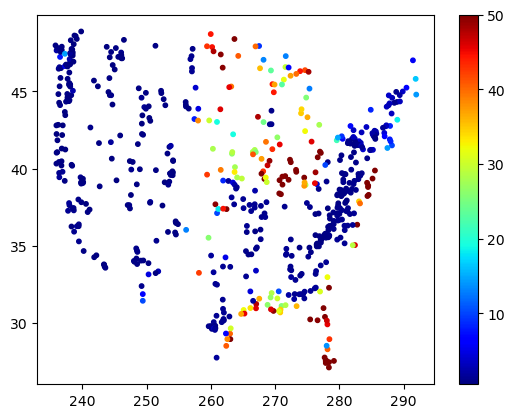

In [19]:
import matplotlib.pyplot as plt
plt.scatter(ds.LONGXY, ds.LATIXY, 10, ds.zbedrock, cmap='jet')
plt.colorbar()

In [76]:
r=[]
for i in range(200):
    df = pd.read_pickle(f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/SA_HH_allbasins/level1/param_sets/paramset_iter0_trial{i}.pkl')
    r.append((ds.zbedrock.values / df.iloc[9]['Value'])[0])

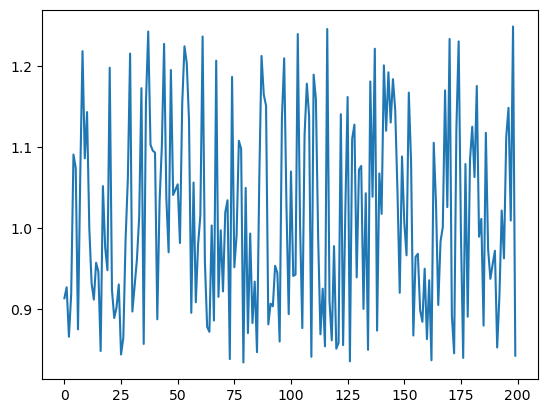

In [78]:
plt.plot(r)

In [47]:
df.iloc[9]

Type                                                       Hydrology
Process                                       Soil storage capacity 
PPE_DailyQ_Rank                                                    0
Parameter                                                   zbedrock
Default                                                    10.639669
Lower                                                          8.512
Upper                                                         12.768
LowUp_vsPPE                                                     Same
Source                                                      Surfdata
Binding                                                         None
Factor                                                        0.7375
Value              [6.2299373608089015, 15.386533551606846, 18.06...
Name: 9, dtype: object

In [80]:
12.768/10.639669

1.2000373319884294

In [34]:
ds=xr.load_dataset('/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/sfcdata/surfdata_CAMELSandTDX_areabias_fix.simp0.001.level1_hist_78pfts_CMIP6_simyr2000_HAND_4_col_hillslope_geo_params_nlcd_bedrock.nc')
ds.zbedrock

<xarray.DataArray 'zbedrock' (gridcell: 627)>
array([ 5.68926355, 14.05119176, 16.49982196,  6.42583562,  3.47945492,
        1.19048495,  0.79723011,  1.9373509 ,  3.19491707, 18.47878235,
        3.3578268 ,  9.98355924,  7.69467768,  8.42513789,  2.87891656,
        1.20602436,  3.30034458,  2.71319083,  3.08200576,  8.35741023,
        3.49380548,  3.28664184,  4.34600396,  6.15992986, 14.31956062,
        1.60685275,  1.61472483,  2.42593041,  2.51585445,  0.73686248,
       50.        ,  1.08409846,  0.95766993,  2.01879773,  2.1498184 ,
        0.67450175,  3.03158848,  3.33355503,  1.67502818,  1.07871136,
       50.        , 50.        , 50.        , 50.        , 50.        ,
       50.        ,  3.55504596,  4.17435719,  2.97286602,  3.01434401,
        3.97794373,  0.79289781,  0.76404876,  0.78908876,  0.83639333,
        0.83927859,  0.89845245,  0.94569726,  3.04622243,  1.35671788,
        0.92984366,  0.98146699,  1.14810426,  1.13615752,  1.16055869,
        1.25735143,  0.96840024,  0.85575364,  0.75069447,  1.09450474,
        0.72346316,  0.79854931,  1.06486723,  0.95918932,  1.20820664,
        1.16911943,  1.14568384,  1.26843262,  1.06428723,  1.0664108 ,
       34.67700381, 39.77474353,  0.80335995,  0.72677442,  0.78469708,
        0.86046993,  0.81011782,  0.91770053,  0.76137578,  0.80998403,
        0.85250132,  1.18326705,  1.35470329,  1.26431043, 49.99634172,
        0.86477283,  1.12003128,  0.98066082,  1.08818255,  1.2270704 ,
...
        1.6034303 ,  1.32439113,  1.1257086 ,  0.74093669,  0.77421943,
        0.69885794,  0.8170771 ,  0.84643232,  0.57674837,  0.64266015,
        0.72763166,  0.63934752,  1.0275743 ,  1.48698078,  0.80328868,
        5.06937109,  0.73226101,  7.82149036,  2.08038745,  0.97161082,
        0.79857251,  0.7013106 ,  0.64150602,  0.65384778, 14.56001524,
        0.68654352,  0.64964651,  2.28464968,  0.66953265,  0.68219856,
        1.0677754 ,  0.56736422,  0.66417281,  1.58278715,  0.95084773,
        0.50683688,  0.84518623,  0.54379484,  0.61045396,  0.56299162,
        0.63779218,  0.88954875,  1.0985068 ,  0.57465948,  0.65788637,
        0.61260799,  0.82389306,  0.77023564,  0.63791424,  0.63805752,
        0.62100704,  0.55754394,  0.64422879,  1.38898687,  0.89740013,
        0.65795538,  0.67232358,  0.85565999,  1.67975946,  0.59762703,
        0.63179459,  0.6537712 ,  0.99624226,  0.64733734,  0.64122699,
        0.80074093,  0.64240222,  0.66469166,  0.82871157,  2.59569253,
        0.73396888,  0.71091597,  0.76225763,  0.79293039,  0.83945698,
        0.8311002 ,  0.66466542,  0.97277171,  0.80491119,  1.03939665,
        0.73815124,  0.72660206,  0.66817567,  0.74519135,  0.77482019,
        0.85607125,  0.72105351,  0.85632704,  0.78037439,  0.74748316,
        0.6906125 ,  0.6743631 ,  0.65096982,  0.63936066,  0.70914799,
        0.58620319,  0.66951336])
Dimensions without coordinates: gridcell
Attributes:
    long_name:  soil depth
    units:      m

In [4]:
(12.768-8.512)*0.29875	+8.512

9.78348

In [6]:
pd.read_csv('/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_Ostrich/level1_626_OSTRICHcalib/parameters/calib_parameter_info.csv')

,Unnamed: 0,Type,Process,PPE_DailyQ_Rank,Parameter,Default_glob,Lower_glob,Upper_glob,Lower_raw,Upper_raw,LowUp_vsPPE,Source,Binding,Method,Default,Lower,Upper,Parameter_Ost,Source_file,OstrichTrial_file
0,0,Hydrology,Infiltration\r\nSoil storage,1,fff,0.500000,0.020000,5.000000,0.020000,5.000000,Same,Param,NaN,Multiplicative,0.500000,0.020000,5.000000,fff_P_mtp,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...
1,1,Hydrology,Soil water drainage,10,hksat_sf,1.000000,0.100000,10.000000,0.100000,10.000000,Same,Param,NaN,Multiplicative,1.000000,0.100000,10.000000,hksat_sf_P_mtp,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...
2,2,Hydrology,Infiltration,0,FMAX,0.381669,0.100000,0.900000,0.100000,0.900000,NotInPPE,Surfdata,NaN,Multiplicative,0.411869,0.107913,0.971213,FMAX_S_mtp,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...
3,3,Snow Processes,Rain/Snow forcing classification,0,precip_repartition_nonglc_all_rain_t,2.000000,0.000000,4.000000,0.000000,4.000000,NotInPPE,Namelist,"precip_repartition_glc_all_rain_t,precip_repar...",Additive,2.000000,0.000000,4.000000,precip_repartition_nonglc_all_rain_t_N_add,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,/glade/work/guoqiang/CTSM_CAMELS/Calib_HH_Ostr...
4,4,Snow Processes,Snow melt,79,n_melt_coef,200.000000,25.000000,600.000000,50.000000,600.000000,BiggerRange_FromYifan,Param,NaN,Multiplicative,200.000000,25.000000,600.000000,n_melt_coef_P_mtp,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...
5,5,Hydrology,Soil storage capacity,9,watsat_sf,1.000000,0.250000,2.000000,0.800000,1.200000,Same,Param,NaN,Multiplicative,1.000000,0.250000,2.000000,watsat_sf_P_mtp,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...
6,6,Stomatal resistance and photosynthesis,ET (transpiration),2,medlynslope,4.840380,1.210095,9.680759,3.235949,6.934051,Same,Param,NaN,Multiplicative,4.840380,1.210095,9.680759,medlynslope_P_mtp,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...
7,7,Hydrology,Infiltration,7,d_max,15.000000,5.000000,100.000000,10.000000,60.000000,Same,Param,NaN,Multiplicative,15.000000,5.000000,100.000000,d_max_P_mtp,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...
8,8,Snow Processes,Snowpack physics,17,zsno,0.000775,0.000010,0.070000,0.000010,0.070000,Same,Param,NaN,Multiplicative,0.000775,0.000010,0.070000,zsno_P_mtp,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...
9,9,Hydrology,Soil storage capacity,0,zbedrock,10.639669,2.670000,21.279338,8.512000,12.768000,Same,Surfdata,NaN,Multiplicative,0.669513,0.168013,1.339027,zbedrock_S_mtp,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...,/glade/campaign/cgd/tss/people/guoqiang/CTSM_C...
